In [1]:
from glob import glob
import pickle as pkl
from typing import Callable, List
import re
import string
import regex
import unicodedata

import spacy

### code mostly take from
- [ColBERT](https://github.com/stanford-futuredata/ColBERT/blob/master/utility/evaluate/annotate_EM.py)
- [DPH](https://github.com/woffett/DensePhrases/blob/main/densephrases/utils/eval_utils.py#L9-L24)

In [2]:
# how DPH does it
def dph_normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


class Tokens(object):
    """A class to represent a list of tokenized text."""
    TEXT = 0
    TEXT_WS = 1
    SPAN = 2
    POS = 3
    LEMMA = 4
    NER = 5

    def __init__(self, data, annotators, opts=None):
        self.data = data
        self.annotators = annotators
        self.opts = opts or {}

    def __len__(self):
        """The number of tokens."""
        return len(self.data)

    def slice(self, i=None, j=None):
        """Return a view of the list of tokens from [i, j)."""
        new_tokens = copy.copy(self)
        new_tokens.data = self.data[i: j]
        return new_tokens

    def untokenize(self):
        """Returns the original text (with whitespace reinserted)."""
        return ''.join([t[self.TEXT_WS] for t in self.data]).strip()

    def words(self, uncased=False):
        """Returns a list of the text of each token
        Args:
            uncased: lower cases text
        """
        if uncased:
            return [t[self.TEXT].lower() for t in self.data]
        else:
            return [t[self.TEXT] for t in self.data]

    def offsets(self):
        """Returns a list of [start, end) character offsets of each token."""
        return [t[self.SPAN] for t in self.data]

    def pos(self):
        """Returns a list of part-of-speech tags of each token.
        Returns None if this annotation was not included.
        """
        if 'pos' not in self.annotators:
            return None
        return [t[self.POS] for t in self.data]

    def lemmas(self):
        """Returns a list of the lemmatized text of each token.
        Returns None if this annotation was not included.
        """
        if 'lemma' not in self.annotators:
            return None
        return [t[self.LEMMA] for t in self.data]

    def entities(self):
        """Returns a list of named-entity-recognition tags of each token.
        Returns None if this annotation was not included.
        """
        if 'ner' not in self.annotators:
            return None
        return [t[self.NER] for t in self.data]

    def ngrams(self, n=1, uncased=False, filter_fn=None, as_strings=True):
        """Returns a list of all ngrams from length 1 to n.
        Args:
            n: upper limit of ngram length
            uncased: lower cases text
            filter_fn: user function that takes in an ngram list and returns
              True or False to keep or not keep the ngram
            as_string: return the ngram as a string vs list
        """

        def _skip(gram):
            if not filter_fn:
                return False
            return filter_fn(gram)

        words = self.words(uncased)
        ngrams = [(s, e + 1)
                  for s in range(len(words))
                  for e in range(s, min(s + n, len(words)))
                  if not _skip(words[s:e + 1])]

        # Concatenate into strings
        if as_strings:
            ngrams = ['{}'.format(' '.join(words[s:e])) for (s, e) in ngrams]

        return ngrams

    def entity_groups(self):
        """Group consecutive entity tokens with the same NER tag."""
        entities = self.entities()
        if not entities:
            return None
        non_ent = self.opts.get('non_ent', 'O')
        groups = []
        idx = 0
        while idx < len(entities):
            ner_tag = entities[idx]
            # Check for entity tag
            if ner_tag != non_ent:
                # Chomp the sequence
                start = idx
                while (idx < len(entities) and entities[idx] == ner_tag):
                    idx += 1
                groups.append((self.slice(start, idx).untokenize(), ner_tag))
            else:
                idx += 1
        return groups


class Tokenizer(object):
    """Base tokenizer class.
    Tokenizers implement tokenize, which should return a Tokens class.
    """

    def tokenize(self, text):
        raise NotImplementedError

    def shutdown(self):
        pass

    def __del__(self):
        self.shutdown()


class SimpleTokenizer(Tokenizer):
    ALPHA_NUM = r'[\p{L}\p{N}\p{M}]+'
    NON_WS = r'[^\p{Z}\p{C}]'

    def __init__(self, **kwargs):
        """
        Args:
            annotators: None or empty set (only tokenizes).
        """
        self._regexp = regex.compile(
            '(%s)|(%s)' % (self.ALPHA_NUM, self.NON_WS),
            flags=regex.IGNORECASE + regex.UNICODE + regex.MULTILINE
        )
        if len(kwargs.get('annotators', {})) > 0:
            logger.warning('%s only tokenizes! Skipping annotators: %s' %
                           (type(self).__name__, kwargs.get('annotators')))
        self.annotators = set()

    def tokenize(self, text):
        data = []
        matches = [m for m in self._regexp.finditer(text)]
        for i in range(len(matches)):
            # Get text
            token = matches[i].group()

            # Get whitespace
            span = matches[i].span()
            start_ws = span[0]
            if i + 1 < len(matches):
                end_ws = matches[i + 1].span()[0]
            else:
                end_ws = span[1]

            # Format data
            data.append((
                token,
                text[start_ws: end_ws],
                span,
            ))
        return Tokens(data, self.annotators)


STokenizer = SimpleTokenizer()


def DPR_tokenize(text):
    return STokenizer.tokenize(unicodedata.normalize('NFD', text))


def DPR_normalize(text):
    return DPR_tokenize(text).words(uncased=True)

def has_answer(tokenized_answers, text):
    text = DPR_normalize(text)

    for single_answer in tokenized_answers:
        for i in range(0, len(text) - len(single_answer) + 1):
            if single_answer == text[i: i + len(single_answer)]:
                return True

    return False

def dpr_has_answer(passage: str, answers: List[str]) -> bool:
    answers_tok = map(DPR_normalize, answers)
    return has_answer(answers_tok, passage)

def dph_has_answer(passage: str, answers: List[str]):
    return any(
        dph_normalize_answer(a) in dph_normalize_answer(passage)
        for a in answers
    )

### sanity checks

In [3]:
assert dpr_has_answer('hello this is some long text', ['text', 'some long!'])
assert dpr_has_answer('HeLLo ThIs is some text!@ yellow', ['this is some'])
assert dph_has_answer('heLLo thIs is some Text!@ yellow', ['this is'])
assert dph_has_answer('Text!@ yellow', ['text yellow'])
assert not dph_has_answer('this is text', ['hello'])

### get data

In [4]:
!ls -lh *.pkl

-rw-r--r-- 1 root root  25K May 30 00:51 answers.pkl
-rw-r--r-- 1 root root 8.1M May 30 00:51 evidences.pkl
-rw-r--r-- 1 root root 238K May 30 00:51 predictions.pkl
-rw-r--r-- 1 root root  14K May 30 00:51 qids.pkl
-rw-r--r-- 1 root root    4 May 30 00:51 q_tokens.pkl
-rw-r--r-- 1 root root  42K May 30 00:51 questions.pkl
-rw-r--r-- 1 root root  95K May 30 00:51 scores.pkl
-rw-r--r-- 1 root root 347K May 30 00:51 titles.pkl


In [5]:
vals = {
    f.split('.pkl')[0]: pkl.load(open(f, 'rb'))
    for f in glob('*.pkl')
    if 'q_tokens' not in f  # this is empty
}
iters = ['answers', 'scores', 'titles', 'predictions', 'evidences']
vals.keys()

dict_keys(['questions', 'answers', 'scores', 'titles', 'qids', 'predictions', 'evidences'])

### evidence <=> paragraph

In [6]:
vals['evidences'][0][0]

'Today\'s autodialer supposedly runs a smarter software, claiming a less than 2% hangup rate. However, most telemarketing companies place thousands of calls an hour, bringing that 2% back up to an annoying level. Ray Bradbury wrote a story, "Number of the ghost - 777888999", about a telephone switch box that gained sentience. Its first order of business in the world, stalking. Eventually the person documenting the calls traced it down to a specific phone box and was summarily executed by said box through electrocution.'

### sanity check: predictions are extracted from the "evidence"

In [7]:
vals['predictions'][0]

['electrocution.',
 'nasal fracture',
 'spasmodic dysphonia.',
 'exaggerated jaw vibrato"',
 'straining his vocal cords',
 'kidney failure',
 'Botox shots',
 'weak',
 'drugs',
 'a bizarre accident',
 'A middle ear infection',
 'falling from a ladder',
 'scarlet fever and measles.',
 'throat cancer surgery',
 'digitally erased',
 'abductor spasmodic dysphonia,']

In [8]:
vals['predictions'][0][0]

'electrocution.'

In [9]:
assert all(
    p in e
    for es, ps in zip(vals['evidences'], vals['predictions'])
    for e, p in zip(es, ps)
)

### sanity check: make sure things are the same length

In [10]:
assert all(
    len(s) == len(e) == len(p) == len(t)
    for s, e, p, t in zip(
        vals['scores'],
        vals['evidences'],
        vals['predictions'],
        vals['titles'],
    )
)

### sanity check: all scores are sorted

In [11]:
assert all(
    s == sorted(s, reverse=True)
    for s in vals['scores']
)

### success @ k

In [12]:
# takes passage and list of answers, returns bool
HasAnswerFn = Callable[[str, List[str]], bool]

def success_at_k_one(
    answers: List[str],
    evidences: List[str],
    k: int,
    has_answer_fn: HasAnswerFn,
) -> bool:
    """
    for a single instance.
    
    any of the answers is found in the top k evidence / paragraph
    this assumes that the evidence is in the same sorted order as `scores`
    """
    return any(
        has_answer_fn(e, answers)
        for e in evidences[:k]
    )

def success_at_k(
    answers: List[List[int]],
    evidences: List[List[str]],
    k: int,
    has_answer_fn: HasAnswerFn = dph_has_answer,
) -> float:
    """
    for a collection. just count the fraction of success@k's.
    """
    n = len(answers)
    return sum(
        success_at_k_one(a, e, k, has_answer_fn)
        for a, e in zip(answers, evidences)
    ) / n

### compute for different values of `k`

In [14]:
has_answer_fns = [
    ('DPH', dph_has_answer),
    ('DPR', dpr_has_answer),
]
ks = range(1, 20 + 1)
df = pd.DataFrame(
    {
        "k": k,
        "method": name, 
        "Success @ K": success_at_k(
            vals['answers'],
            vals['evidences'],
            k,
            has_answer_fn=fn,
        ),
    }
    for k in ks
    for name, fn in has_answer_fns
)

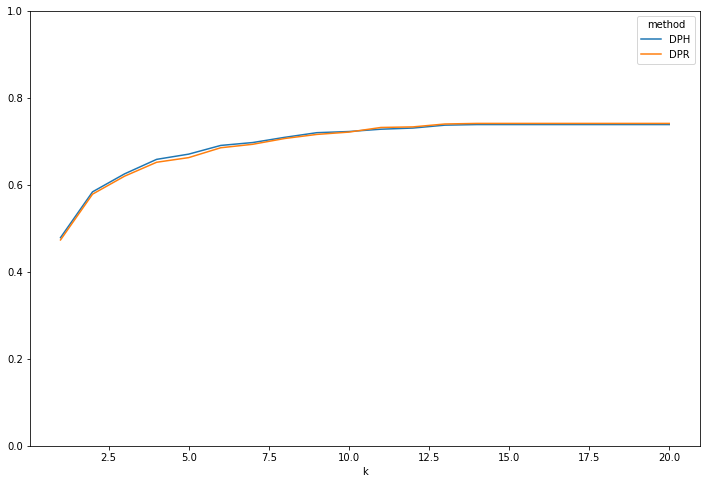

In [15]:
df.pivot_table(values='Success @ K', index='k', columns='method').plot(figsize=(12, 8))
_ = plt.ylim([0, 1])